In [8]:
using LinearAlgebra
using Plots
using SparseArrays
using Polynomials
using SymRCM

# Functions from last week

In [9]:
function xy(x0::Float64, y0::Float64, L1::Float64, L2::Float64, noelms1::Int64, noelms2::Int64)
    # Computes the x-coordinates and y-coordinates in a given range, with a given grid definition.
    # Author: Clara Hollenbeck
    # x0, y0: minimum x and y value
    # L1, L", maximum x and y value respectively
    # noelms1, noelms2: no. of elements in the x and y direction respectively.

    VX= repeat(collect(LinRange(x0, x0 + L1, noelms1+1)), inner = noelms2+1)
    VY = repeat(collect(LinRange(y0 + L2, y0, noelms2+1)), noelms1+1)
    return VX, VY
end

function conelmtab(noelms1::Int64, noelms2::Int64)
    novertices = noelms1 *noelms2*2
    EToV = zeros(Int64, novertices, 3)

    for i in 1: noelms1
        v1 = collect(range(1, noelms2)) .+ (noelms2+1)*(i-1)
        v2 = collect(range(noelms2 + 3, 2*noelms2+2)) .+ (noelms2+1)*(i-1)
        v3 = collect(range(noelms2 + 2, 2*noelms2 +1)) .+ (noelms2+1)*(i-1)
        v4 = collect(range(2 , noelms2+1)) .+ (noelms2+1)*(i-1)

        EToV[1 + noelms2*2 *(i-1) : noelms2*2 *i , :] = vcat(hcat(v1,v2,v3), hcat(v1, v4, v2))
    end
    return EToV[sortperm(EToV[:, 1]), :]
end

function basfun(VX, VY, EToV)
    xks = VX[EToV[:, [3,1,2]]]
    xjs = VX[EToV[:, [2,3,1]]]
    yks = VY[EToV[:, [3,1,2]]]
    yjs = VY[EToV[:, [2,3,1]]]

    as = xjs .* yks .- xks .* yjs
    bs = yjs .- yks
    cs = xks .- xjs

    deltas = sum(as, dims=2)./2
    return bs,cs, deltas
end

function constructBeds(
    VX::Vector{Float64},
    VY::Vector{Float64},
    EToV::Matrix{Int64},
    tol::Float64,
    fd::Function,
)::Matrix{Int64}
    xc = (VX[EToV] + VX[EToV[:, [2, 3, 1]]]) ./ 2
    yc = (VY[EToV] + VY[EToV[:, [2, 3, 1]]]) ./ 2
    return getindex.(findall(abs.(fd.(xc, yc)) .<= tol), [1 2])
end

function constructBnodes(
    VX::Vector{Float64},
    VY::Vector{Float64},
    tol::Float64,
    fd::Function,
)::Vector{Int64}
    return findall(abs.(fd.(VX, VY)) .<= tol)
end

constructBnodes (generic function with 1 method)

# Time dependent assembly

In [10]:
function assembly(
    VX::Vector{Float64},
    VY::Vector{Float64},
    EToV::Matrix{Int64},
    lam1::Float64,
    lam2::Float64,
    qt::Vector{Float64},
    ct::Vector{Float64}
)::Tuple{SparseMatrixCSC{Float64, Int64}, SparseMatrixCSC{Float64, Int64}, Vector{Float64}}
    N = size(EToV)[1]
    M = length(VX)

    R = spzeros(M, M)
    S = spzeros(M, M)
    B = zeros(M)

    bs, cs, deltas = basfun(VX, VY, EToV)
    qs = abs.(deltas) .* sum(qt[EToV], dims=2) / 9

    C = [2 1 1; 1 2 1; 1 1 2]./12

    for n in 1:N
        delta = deltas[n]
        q = qs[n]
        b = bs[n, :]
        c = cs[n, :]

        for r in 1:3
            i = EToV[n,r]
            B[i] += q

            for s in r:3
                j = EToV[n,s]
                i2 = min(i, j)
                j2 = max(i, j)
                kn = (lam1*b[r]*b[s] + lam2*c[r]*c[s]) / (4 * abs(delta))
                cn = ct[i]*C[r, s]*abs(deltas[n])
                R[i2, j2] += kn
                S[i2, j2] += cn
            end
        end
    end

    return R, S, B
end

assembly (generic function with 1 method)

In [101]:
function dirbc(
    bnodes::Vector{Int64}, 
    f::Vector{Float64}, 
    R::SparseMatrixCSC{Float64, Int64}, 
    S::SparseMatrixCSC{Float64, Int64}, 
    b::Vector{Float64}
)::Tuple{SparseMatrixCSC{Float64, Int64}, SparseMatrixCSC{Float64, Int64}, Vector{Float64}, Vector{Float64}}
    d = zeros(length(b))
    for (i, k) in enumerate(bnodes)
        b[k] = 0

        indices1R = findall(R[1:k-1, k] .!= 0) 
        indices2R = findall(R[k, 1+k:end] .!= 0) .+ k
        indices1S = findall(S[1:k-1, k] .!= 0) 
        indices2S = findall(S[k, 1+k:end] .!= 0) .+ k

        temp1 = R[indices1R,k] .* f[i]
        temp2 = R[k,indices2R] .* f[i]

        b[indices1R] -= temp1
        b[indices2R] -= temp2

        d[indices1R] += temp1
        d[indices2R] += temp2

        R[indices1R, k] .= 0
        R[k, indices2R] .= 0
        S[indices1S, k] .= 0
        S[k, indices2S] .= 0
        
        S[k, k] = 1
        R[k,k] = 0
    end

    return R, S, b, d
end

dirbc (generic function with 1 method)

# Solver

In [12]:
function solveTDDBVP(R, S, un)
    # Solves a time dependendent dirichlet boundary value problem
    e = S*un
    u_np1 = R\e
    return u_np1
end 

solveTDDBVP (generic function with 1 method)

# Test

Test of assembly and dirbc

In [89]:
lam1 = lam2 = nu = 2.0
noelms1 = 3
noelms2 = 4
x0 = 0.0
y0 = 0.0
L1 = 1.0
L2 = 1.0
tol = 0.01

ct(x,y) = 1.0
qt(x,y) = 0.0
f(x,y) = 0.0
distD(x, y) = min(x-x0, y-y0,x0+L1-x, y0+L2-y)        # This is the dirichlet boundary condition

VX, VY = xy(x0, y0, L1, L2, noelms1, noelms2)
EToV = conelmtab(noelms1, noelms2)
bnodes = constructBnodes(VX, VY, tol, distD)

R, S, b = assembly(VX, VY, EToV, lam1, lam2, qt.(VX, VY), ct.(VX,VY))
R, S, b, d = dirbc(bnodes,f.(VX,VY),R,S,b)
#display(spy(R,markersize=5))
#display(spy(S,markersize=5))
#display(b)
#display(d)

(sparse([1, 1, 2, 2, 3, 3, 4, 4, 5, 1  …  17, 13, 17, 18, 14, 18, 19, 15, 19, 20], [1, 2, 2, 3, 3, 4, 4, 5, 5, 6  …  17, 18, 18, 18, 19, 19, 19, 20, 20, 20], [2.083333333333334, 0.0, 4.166666666666666, 0.0, 4.166666666666666, 0.0, 4.166666666666667, 0.0, 2.0833333333333335, 0.0  …  4.166666666666666, 0.0, 0.0, 4.166666666666668, 0.0, 0.0, 4.166666666666666, 0.0, 0.0, 2.083333333333333], 20, 20), sparse([1, 1, 2, 2, 3, 3, 4, 4, 5, 1  …  17, 18, 13, 14, 18, 19, 14, 15, 19, 20], [1, 2, 2, 3, 3, 4, 4, 5, 5, 6  …  18, 18, 19, 19, 19, 19, 20, 20, 20, 20], [1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0  …  0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0], 20, 20), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

Test of solver

In [106]:
noelms1 = 20
noelms2 = 20
x0 = 0.0
y0 = 0.0
L1 = 1.0
L2 = 1.0
tol = 0.001
v = 1
dt = 0.05
theta = 1

ct(x,y) = 1.0
qt(x,y) = 0.0
u(x,y,t) = exp(-2*pi^2*v*t)*sin(pi*x)*sin(pi*y)                 # This is the analytical solution to the problem
g(x,y) = sin(pi*x)*sin(pi*y)                                    # This is u(x,y,0) 
f(x,y) = 0.0                                                    # This is the dirichlet boundary condition
ut(x,y,t) = v *(-2*exp(-2*pi^2*v*t)*pi^2*sin(pi*x)*sin(pi*y))   # This is the time derivative of u(x,y,t)
distD(x, y) = min(x-x0, y-y0,x0+L1-x, y0+L2-y)                  # This is the distance function for the dirichlet boundary

VX, VY = xy(x0, y0, L1, L2, noelms1, noelms2)
EToV = conelmtab(noelms1, noelms2)
bnodes = constructBnodes(VX, VY, tol, distD)
R, S, b = assembly(VX, VY, EToV, lam1, lam2, qt.(VX, VY), ct.(VX,VY))
R, S, b, d = dirbc(bnodes,f.(VX,VY), R,S,b)

d2 = dt*(1-theta)
S -= d2.*R
R = S .+ dt.*R

R = Symmetric(R)
S = Symmetric(S)

uhat = g.(VX, VY)

N = 40
t=0
errors = zeros(N)
uhats = zeros(length(VX), N)
uhats[:, 1] = uhat

for i in 2:N
    t += dt
    uhat = solveTDDBVP(R, S, uhat) 
    uhats[:, i] = uhat
    errors[i] = maximum(abs, uhat .- u.(VX, VY, t))
end



[ Info: Saved animation to c:\Users\clar1\OneDrive\Dokumenter\DTU\5. semester\FEM\code\week 3\Theta05.gif


Plots.AnimatedGif("c:\\Users\\clar1\\OneDrive\\Dokumenter\\DTU\\5. semester\\FEM\\code\\week 3\\Theta05.gif")
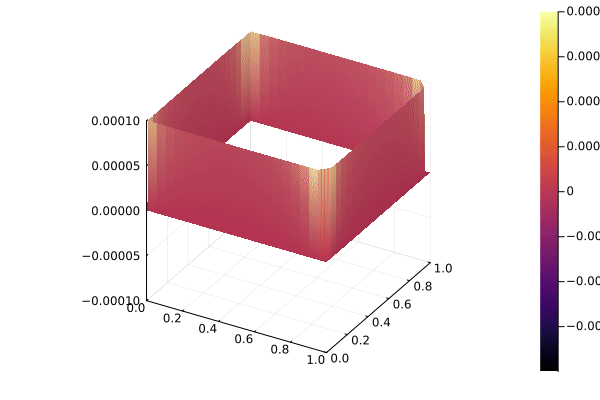

In [100]:

anim = @animate for i in 3:N
    plot(VX, VY, uhats[:,i], st=:surface, zlims=(-0.0001,0.0001), clims =(-0.0001,0.0001))
end
gif(anim, "ignore.gif"; fps = 3)

### Convergence